
# Classificação Binária com Keras — Regressão Logística no UCI Adult

**Objetivo da atividade**  
Construir um modelo sequencial no Keras com **uma única camada Dense** (1 unidade, **sigmoid**) para uma tarefa de **classificação binária**, treinar por **50 épocas** com **batch size = 10** e avaliar com **Accuracy** e **F1**. As decisões e etapas estão explicadas em células *markdown*.

**Dataset escolhido: UCI Adult (Census Income)**  
Tarefa: prever se a renda anual é `>50K`. É um conjunto com ~48 mil amostras, atributos numéricos e categóricos, presença de valores faltantes e leve desbalanceamento de classes. Trata-se de um problema real e amplamente usado como benchmark, portanto **não é** um dataset "toy".



## 1) Preparação: bibliotecas e ideia geral

- **pandas / numpy**: manipulação de dados e arrays.
- **scikit-learn**: divisão treino/teste, padronização e métricas (Accuracy e F1).
- **TensorFlow / Keras**: definição, compilação e treinamento do modelo.
- **matplotlib**: visualização das curvas de treinamento.

A estratégia será: carregar os dados brutos da UCI, fazer exploração rápida, aplicar pré-processamento mínimo e treinar um modelo **logístico** (camada Dense com sigmoid). Em seguida, avaliar em teste com **Accuracy** e **F1** e interpretar os resultados.


In [3]:
import sys
print(sys.executable)  # só para conferir qual Python o kernel está usando
%pip install --upgrade pip
%pip install numpy pandas matplotlib scikit-learn tensorflow


c:\Users\psant\AppData\Local\Programs\Python\Python313\python.exe
Note: you may need to restart the kernel to use updated packages.
  Using cached numpy-2.3.2-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached pandas-2.3.1-cp313-cp313-win_amd64.whl.metadata (19 kB)
  Using cached matplotlib-3.10.5-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached scikit_learn-1.7.1-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached tensorflow-2.20.0-cp313-cp313-win_amd64.whl.metadata (4.6 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.59.0-cp313-cp313-win_amd64.whl.metadata (110 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-11.3.0-cp313-cp313-win_amd64.whl.metadata (9.2 kB)


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


c:\Users\psant\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\psant\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\psant\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framewo


## 2) Carregamento do dataset

Usaremos o arquivo `adult.data` da UCI. A última coluna é o alvo (`income`), com rótulos `<=50K` e `>50K`. As colunas categóricas incluem, por exemplo, `workclass`, `education`, `marital-status`, `occupation`, entre outras; as numéricas incluem `age`, `hours-per-week`, `capital-gain` e `capital-loss`.


In [5]:

columns = [
    "age","workclass","fnlwgt","education","education-num","marital-status",
    "occupation","relationship","race","sex","capital-gain","capital-loss",
    "hours-per-week","native-country","income"
]
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
df = pd.read_csv(url, names=columns, na_values="?", sep=",", skipinitialspace=True)
df.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K



## 3) Exploração rápida

Aqui verificamos volume de dados, nomes das colunas, distribuição do alvo e valores faltantes. Isso ajuda a entender a complexidade e orientar o pré-processamento.


In [6]:

n_rows = len(df)
cols = list(df.columns)
target_dist = df["income"].value_counts(dropna=False)
missing = df.isna().sum()
n_rows, cols, target_dist, missing


(32561,
 ['age',
  'workclass',
  'fnlwgt',
  'education',
  'education-num',
  'marital-status',
  'occupation',
  'relationship',
  'race',
  'sex',
  'capital-gain',
  'capital-loss',
  'hours-per-week',
  'native-country',
  'income'],
 income
 <=50K    24720
 >50K      7841
 Name: count, dtype: int64,
 age                  0
 workclass         1836
 fnlwgt               0
 education            0
 education-num        0
 marital-status       0
 occupation        1843
 relationship         0
 race                 0
 sex                  0
 capital-gain         0
 capital-loss         0
 hours-per-week       0
 native-country     583
 income               0
 dtype: int64)


## 4) Pré-processamento

Passos básicos para um baseline reprodutível:
1. Remover linhas com faltantes para simplificar o baseline.
2. Converter o alvo para binário: `>50K` → 1, caso contrário 0.
3. Codificar variáveis categóricas com *one-hot encoding*.
4. Separar treino e teste com estratificação para manter a proporção da classe.
5. Padronizar as features numéricas com `StandardScaler` para facilitar a otimização.


In [7]:

df = df.dropna().copy()
df["income"] = (df["income"].str.strip() == ">50K").astype(int)
y = df["income"].values
X = df.drop(columns=["income"])
X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values.astype(np.float32))
X_test_scaled = scaler.transform(X_test.values.astype(np.float32))
X_train.shape, X_test.shape


((24129, 96), (6033, 96))


## 5) Métrica F1 no Keras

A **F1** é a média harmônica entre **precision** e **recall**, útil em casos com leve desbalanceamento de classes, pois penaliza mais quando há desequilíbrio entre falsos positivos e falsos negativos.  
Aqui implementamos uma métrica F1 simples dentro do Keras com limiar 0,5 para transformar probabilidades em rótulos durante o cálculo por época.


In [8]:

class F1Score(keras.metrics.Metric):
    def __init__(self, name="f1", threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name="tp", initializer="zeros")
        self.fp = self.add_weight(name="fp", initializer="zeros")
        self.fn = self.add_weight(name="fn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.bool)
        y_pred = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
        preds = tf.greater_equal(y_pred, self.threshold)
        preds = tf.cast(preds, tf.bool)
        tp = tf.logical_and(y_true, preds)
        fp = tf.logical_and(tf.logical_not(y_true), preds)
        fn = tf.logical_and(y_true, tf.logical_not(preds))
        tp = tf.reduce_sum(tf.cast(tp, self.dtype))
        fp = tf.reduce_sum(tf.cast(fp, self.dtype))
        fn = tf.reduce_sum(tf.cast(fn, self.dtype))
        self.tp.assign_add(tp)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)

    def result(self):
        precision = self.tp / (self.tp + self.fp + 1e-7)
        recall = self.tp / (self.tp + self.fn + 1e-7)
        return 2.0 * precision * recall / (precision + recall + 1e-7)

    def reset_state(self):
        for v in self.variables:
            v.assign(0.0)



## 6) Modelo sequencial com uma camada Dense (sigmoid)

O modelo abaixo é equivalente a uma **regressão logística**.  
- **`optimizer='adam'`**: otimizador com taxa de aprendizado adaptativa.  
- **`loss='binary_crossentropy'`**: perda apropriada para classificação binária.  
- **`metrics=['accuracy', F1Score()]`**: acompanhamos Accuracy e F1 por época.


In [9]:

n_features = X_train_scaled.shape[1]
model = keras.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", F1Score()])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97 (388.00 B)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 0 (0.00 B)


## 7) Treinamento

Treinaremos por **50 épocas** com **batch size = 10**. Separamos automaticamente parte do treino como validação para acompanhar overfitting/underfitting.


In [10]:

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=10,
    verbose=1
)


Epoch 1/50
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7629 - f1: 0.5837 - loss: 0.5366 - val_accuracy: 0.8303 - val_f1: 0.6519 - val_loss: 0.4753
Epoch 2/50
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8378 - f1: 0.6442 - loss: 0.3849 - val_accuracy: 0.8402 - val_f1: 0.6608 - val_loss: 0.4411
Epoch 3/50
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8435 - f1: 0.6510 - loss: 0.3545 - val_accuracy: 0.8433 - val_f1: 0.6713 - val_loss: 0.4246
Epoch 4/50
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8461 - f1: 0.6563 - loss: 0.3409 - val_accuracy: 0.8460 - val_f1: 0.6725 - val_loss: 0.4138
Epoch 5/50
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8458 - f1: 0.6564 - loss: 0.3343 - val_accuracy: 0.8440 - val_f1: 0.6664 - val_loss: 0.4053
Epoch 6/50
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8470 - f1: 0.6565 - loss: 0.3303 - val_accuracy: 0.8475 - val_f1: 0.6691 - val_loss: 0.3987
Epoch 7/50
1931/1931 ━━━━━━━━━━━━━━━━━━━


## 8) Curvas de treinamento

As curvas ajudam a verificar se o modelo está aprendendo de forma estável e se há overfitting (por exemplo, validação piorando enquanto treino melhora).


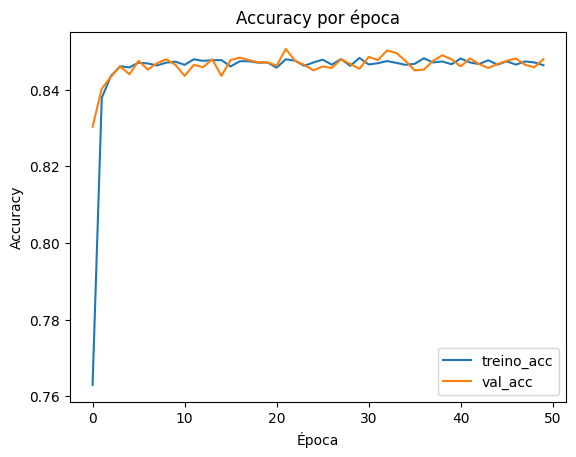

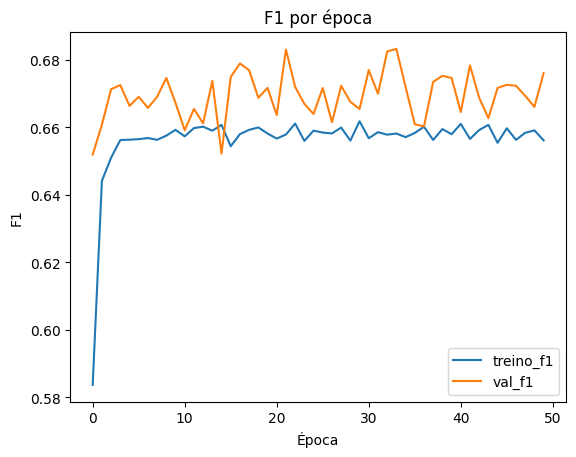

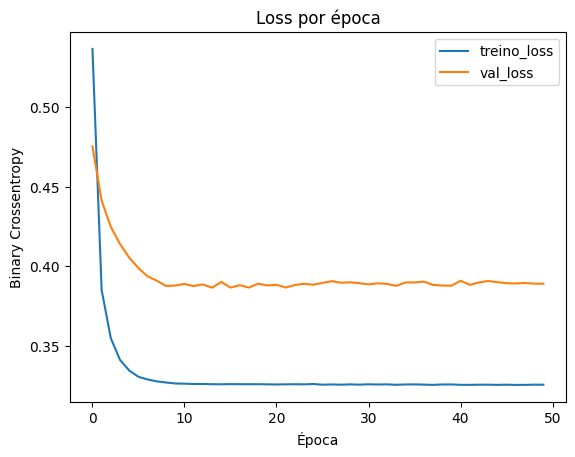

In [11]:

plt.figure()
plt.plot(history.history["accuracy"], label="treino_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy por época")
plt.show()

if "f1" in history.history:
    plt.figure()
    plt.plot(history.history["f1"], label="treino_f1")
    plt.plot(history.history["val_f1"], label="val_f1")
    plt.xlabel("Época")
    plt.ylabel("F1")
    plt.legend()
    plt.title("F1 por época")
    plt.show()

plt.figure()
plt.plot(history.history["loss"], label="treino_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Época")
plt.ylabel("Binary Crossentropy")
plt.legend()
plt.title("Loss por época")
plt.show()



## 9) Avaliação no conjunto de teste

Calcularemos **Accuracy** e **F1** no teste, além da matriz de confusão e do *classification report*. Em seguida, discutimos os resultados e melhorias possíveis.


In [12]:

y_proba = model.predict(X_test_scaled)
y_hat = (y_proba >= 0.5).astype(int).ravel()
acc = accuracy_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat)
cm = confusion_matrix(y_test, y_hat)
report = classification_report(y_test, y_hat, digits=4)
print(f"Accuracy (teste): {acc:.4f}")
print(f"F1 (teste): {f1:.4f}")
print("Matriz de confusão:")
print(cm)
print("Classification report:")
print(report)


189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
Accuracy (teste): 0.8463
F1 (teste): 0.6608
Matriz de confusão:
[[4203  328]
 [ 599  903]]
Classification report:
              precision    recall  f1-score   support

           0     0.8753    0.9276    0.9007      4531
           1     0.7335    0.6012    0.6608      1502

    accuracy                         0.8463      6033
   macro avg     0.8044    0.7644    0.7807      6033
weighted avg     0.8400    0.8463    0.8410      6033




## 10) Interpretação e possíveis melhorias

Com base nos resultados, o modelo acerta cerca de 85% dos casos no teste (accuracy = 0,8463) e apresenta F1 = 0,6608 para a classe >50K, o que indica um desempenho razoável na classe minoritária, mas ainda com perdas relevantes. Pela matriz de confusão, vemos 903 verdadeiros positivos e 4203 verdadeiros negativos, enquanto 328 pessoas com renda ≤50K foram marcadas como >50K (falsos positivos) e 599 pessoas com renda >50K ficaram como ≤50K (falsos negativos), mostrando que o modelo tende a “deixar passar” alguns positivos. As curvas de treino e validação ficam próximas e estáveis, sugerindo que não há overfitting relevante e que o aprendizado estabiliza cedo; treinar muito mais não deve mudar o resultado. Para melhorar sem complicar, o mais direto é ajustar o limite de decisão (threshold) em vez de fixar 0,5, buscando um ponto que aumente o recall da classe >50K e, por consequência, o F1; outra medida simples é usar class_weight para dar um peso maior à classe positiva e reduzir falsos negativos. Se for necessário um passo além, pequenas melhorias de dados (como criar faixas de idade ou de horas trabalhadas) ou um modelo levemente mais expressivo (uma camada escondida pequena) podem capturar relações não lineares e trazer ganhos adicionais. Em resumo, o resultado está dentro do esperado para uma regressão logística no Adult e, com um ajuste básico de threshold e pesos de classe, já deve ser possível elevar o F1 sem grandes mudanças no código.
